In [1]:
# imports 
import emp_preprocessing as ep
import emp_fake_data as ef
import emp_metrics as em
import emp_graphics as eg
import networkx as nx
import graphics as gx
import functions as fct
import numpy as np
import pandas as pd
import parameters as par

# parameters
agg_periods = [1, 50, 100, 250]
path_results = "./results/empirical_results/"

# 1 data preprocessing

In [ ]:
# load fake data (mmsr)
df_mmsr = ef.get_df_mmsr(nb_tran=int(1e4))
dic_obs_matrix_reverse_repo = ep.build_from_mmsr(df_mmsr=df_mmsr)

In [2]:
# load fake data (exposure)
df_exposures = ef.get_df_exposures(lines=int(1e5))
dic_obs_matrix_reverse_repo = ep.build_from_exposures(df_exposures=df_exposures)

100%|██████████| 100000/100000 [00:32<00:00, 3037.03it/s]


In [ ]:
# load real data 
df_exposures = pd.read_stata("to be filled")
dic_obs_matrix_reverse_repo = ep.build_from_exposures(df_exposures=df_exposures)

In [2]:
# pickle (faster)
dic_obs_matrix_reverse_repo = ep.get_dic_obs_matrix_reverse_repo()

# 2 metrics measurement

In [3]:
# get aggregated adjency matrices
dic_arr_binary_adj = ep.build_rolling_binary_adj(dic_obs_matrix_reverse_repo, agg_periods)

In [3]:
# pickle (faster)
dic_arr_binary_adj = ep.get_dic_dic_binary_adj()

## 2.1 jaccard

In [6]:
# get jaccard
df_jaccard = em.get_jaccard(dic_arr_binary_adj)
eg.plot_jaccard_aggregated(df_jaccard, path_results)

## 2.2 density

In [7]:
# get density
df_density = em.get_density(dic_arr_binary_adj)
eg.plot_network_density(df_density, path_results)

## 2.3 distribution of in and out degree

In [8]:
bank_ids = list(list(dic_obs_matrix_reverse_repo.values())[0].index)

# get degree distribution
dic_in_degree, dic_out_degree = em.get_degree_distribution(dic_arr_binary_adj,bank_ids)
eg.plot_degree_distribution(dic_in_degree,
    dic_out_degree,
    f"{path_results}degree_distribution/",
    name="degree_distribution_reverse_repos",
    save_every=1000)


## 2.4 degree per asset

In [9]:
# build finrep data @NA: add here a read csv of the data with the total assets
df_finrep = ef.get_df_finrep()

# build df_banks
df_banks_emp = em.build_df_banks_emp(df_finrep,dic_in_degree,dic_out_degree,path_results)

# plot
gx.plot_step_degree_per_asset(df_banks_emp, agg_periods, path_results)

## 2.5 core periphery

In [10]:
eg.mlt_run_n_plot_cp_test(dic_arr_binary_adj, algos=par.cp_algos,save_every=1000, path_results=path_results, opt_agg=True)
eg.mlt_run_n_plot_cp_test(dic_obs_matrix_reverse_repo, algos=par.cp_algos,save_every=1000, path_results=path_results, opt_agg=False)

/mnt/live/user/vlecoz/Secured_interbank_network/emp_graphics.py:143: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sr_pvalue = pd.Series()
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/cpnet/qstest.py:94: UserWarning: 'num_of_thread keyword' is duplicated due to a compatibility issue with numba. Only one CPU will be used.
  warnings.warn("'num_of_thread keyword' is duplicated due to a compatibility issue with numba. Only one CPU will be used.")
100%|██████████| 100/100 [00:01<00:00, 59.43it/s]
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/cpnet/qstest.py:94: UserWarning: 'num_of_thread keyword' is duplicated due to a compatibility issue with numba. Only one CPU will be used.
  warnings.warn("'num_of_thread keyword' is duplicated due to a compatibility issue with numba. Only one CPU will be used.")
100%|██████████| 1

# 3 tools

## 3.1 examples of density / histogram in log - log

### pareto law

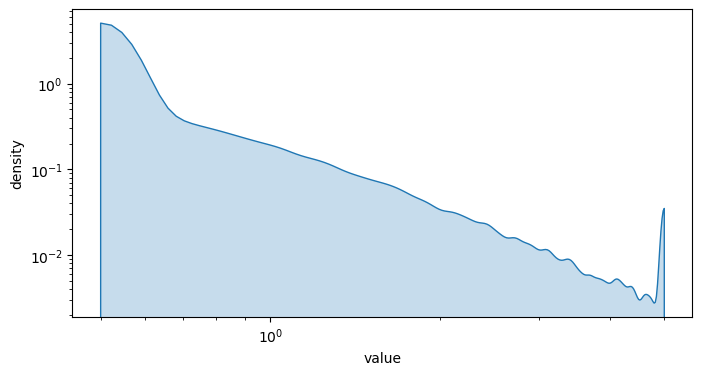

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.pareto(3,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(0.5,5), ax=ax, cut=0, fill=True)
ax.set_xscale('log')

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('value')
ax.set_ylabel('density')

# Show the plot
plt.show()

### student law

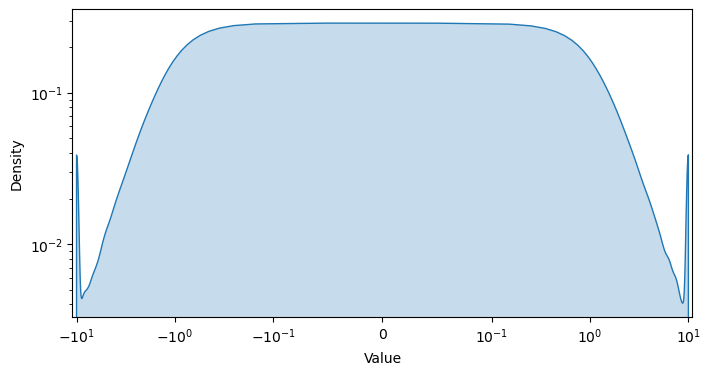

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.standard_t(1,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(-10,10), ax=ax, fill=True, cut=0)
ax.set_xscale('symlog', linthresh=0.1)

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('Value')
ax.set_ylabel('Density')

# Show the plot
plt.show()

## 3.2 multiple histogram on the same plot

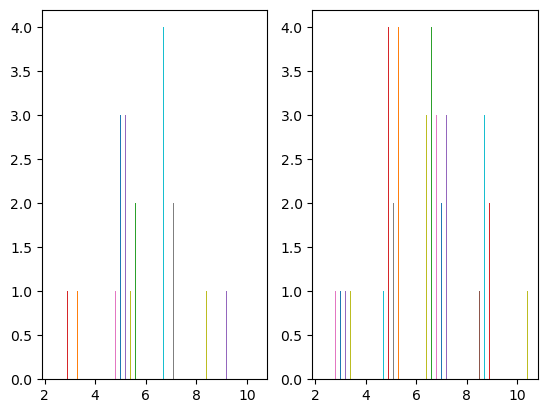

In [7]:
from matplotlib import pyplot as plt

fig, (ax1,ax2) = plt.subplots(1,2)
pos = 0
width = 0.2
for  i in range(10):
    binary_adj = np.random.randint(0,2,(10,10))
    bank_network = nx.from_numpy_array(
                binary_adj,
                parallel_edges=False,
                create_using=nx.DiGraph,
            )  # first define a networkx object.
    ar_in_degree = np.array(bank_network.in_degree())[:,1]
    hist = np.unique(ar_in_degree, return_counts=True)
    ax1.bar(hist[0] + pos, hist[1], width=0.01)
    ax2.bar(hist[0] + pos, hist[1], width=0.01)
    pos = pos +width +0.1



## 3.3 power low fitting

In [19]:
# fitting
import powerlaw
import numpy as np
data = np.random.pareto(3,size=1000) # data can be list or numpy array
fit = powerlaw.Fit(data)
print(fit.power_law.alpha)
print(fit.power_law.xmin)
R, p = fit.distribution_compare('power_law', 'lognormal')

2.516098141817959
0.4844255447194279


Calculating best minimal value for power law fit


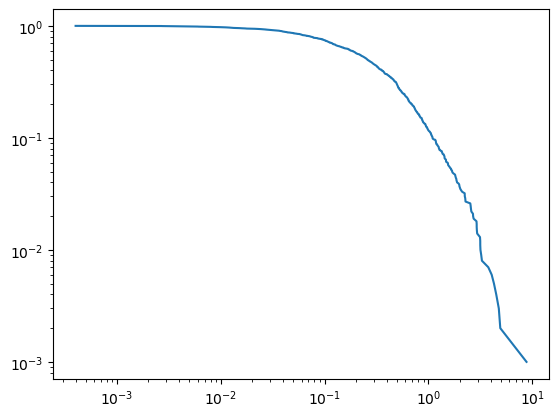

In [22]:
# plotting
ax1 = powerlaw.plot_ccdf(data)

<AxesSubplot: >

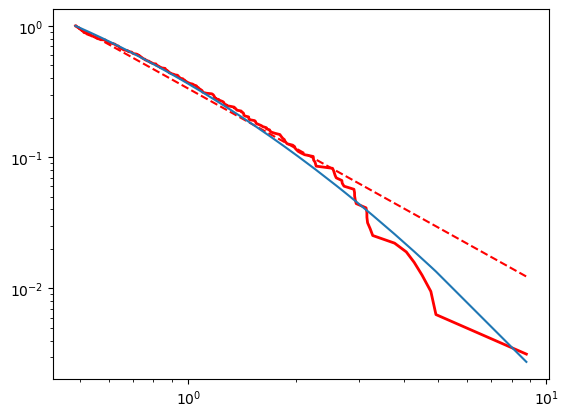

In [31]:
fig2 = fit.plot_ccdf(color = "r", linewidth = 2)
fit.power_law.plot_ccdf(color = "r", linestyle = "--", ax = fig2)
fit.lognormal.plot_ccdf(ax=fig2)